##### Copyright 2023 The TF-Agents Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# REINFORCE agent

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/agents/tutorials/6_reinforce_tutorial">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/6_reinforce_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/6_reinforce_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/agents/docs/tutorials/6_reinforce_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

This example shows how to train a [REINFORCE](https://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf) agent on the Cartpole environment using the TF-Agents library, similar to the [DQN tutorial](1_dqn_tutorial.ipynb).

![Cartpole environment](images/cartpole.png)

We will walk you through all the components in a Reinforcement Learning (RL) pipeline for training, evaluation and data collection.


## Setup

If you haven't installed the following dependencies, run:

In [2]:
!sudo apt-get update
#!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
#!pip install 'imageio==2.4.0'
#!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet xvfbwrapper


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease               
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
#import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy


from envs.trading_env_ext import TradingEnv
from utils import load_dataset

# Set up a virtual display for rendering OpenAI gym environments.
#display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

2023-09-19 15:26:48.618467: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 15:26:48.665151: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 15:26:48.666072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 15:26:50.027904: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Hyperparameters

In [59]:
env_name = "TradingEnv-v0" # @param {type:"string"}
num_iterations = 2000 # @param {type:"integer"}
collect_episodes_per_iteration = 3 # @param {type:"integer"}
replay_buffer_capacity = 2000 # @param {type:"integer"}

fc_layer_params = (100, )

learning_rate = 1e-3 # @param {type:"number"}
learning_rate = 0.0051
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}

## Environment

Environments in RL represent the task or problem that we are trying to solve. Standard environments can be easily created in TF-Agents using `suites`. We have different `suites` for loading environments from sources such as the OpenAI Gym, Atari, DM Control, etc., given a string environment name.

Now let us load the CartPole environment from the OpenAI Gym suite.

In [60]:
env_name = 'TradingEnv-v0'
df = load_dataset('./KO.csv')
env = TradingEnv(df=df, window_size=10, frame_bound=(10, 1500))

/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:335: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == -np.inf] = low
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:336: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == np.inf] = high
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:338: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == -np.inf] = low
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:339: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == np.inf] = high


We can render this environment to see how it looks. A free-swinging pole is attached to a cart.  The goal is to move the cart right or left in order to keep the pole pointing up.

In [61]:
#@test {"skip": true}
# env.reset()
# PIL.Image.fromarray(env.render())

The `time_step = environment.step(action)` statement takes `action` in the environment.  The `TimeStep` tuple returned contains the environment's next observation and reward for that action. The `time_step_spec()` and `action_spec()` methods in the environment return the specifications (types, shapes, bounds) of the `time_step` and `action` respectively.

In [62]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(30,), dtype=dtype('float32'), name='observation', minimum=[-1000. -1000. -1000. -1000. -1000. -1000. -1000. -1000. -1000. -1000.
 -1000. -1000. -1000. -1000. -1000. -1000. -1000. -1000. -1000. -1000.
 -1000. -1000. -1000. -1000. -1000. -1000. -1000. -1000. -1000. -1000.], maximum=[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=6)


So, we see that observation is an array of 4 floats: the position and velocity of the cart, and the angular position and velocity of the pole. Since only two actions are possible (move left or move right), the `action_spec` is a scalar where 0 means "move left" and 1 means "move right."

In [63]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.00716884,  0.0459003 , -0.05306914, -0.04301991,  0.02152431,
       -0.06454422, -0.07491679, -0.0049915 , -0.06992529, -0.07686639,
       -0.00818897, -0.06867742, -0.08129127, -0.0146611 , -0.06663018,
       -0.10713844, -0.04417353, -0.0629649 , -0.09784317, -0.04592165,
       -0.05192152, -0.08761039, -0.04716929, -0.04044111, -0.09363896,
       -0.06499018, -0.02864878, -0.07451703, -0.0621158 , -0.01240124],
      dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.04301991,  0.02152431, -0.06454422, -0.07491679, -0.0049915 ,
       -0.06992529, -0.07686639, -0.00818897, -0.06867742, -0.08129127,
       -0.0146611 , -0.06663018, -0.10713844, -0.04417353, -0.0629649 ,
       -0.09784317, -0.04592165, -0.05192152, -0.08761039, -0.04716929,
       -0.04044111, -0.09

Usually we create two environments: one for training and one for evaluation. Most environments are written in pure python, but they can be easily converted to TensorFlow using the `TFPyEnvironment` wrapper. The original environment's API uses numpy arrays, the `TFPyEnvironment` converts these to/from `Tensors` for you to more easily interact with TensorFlow policies and agents.


In [64]:
train_py_env = env
eval_py_env = TradingEnv(df=df, window_size=10, frame_bound=(1500, 2400))

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:335: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == -np.inf] = low
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:336: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == np.inf] = high
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:338: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == -np.inf] = low
/opt/conda/lib/python3.11/site-packages/tf_agents/specs/array_spec.py:339: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == np.inf] = high


## Agent

The algorithm that we use to solve an RL problem is represented as an `Agent`. In addition to the REINFORCE agent, TF-Agents provides standard implementations of a variety of `Agents` such as [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf), [DDPG](https://arxiv.org/pdf/1509.02971.pdf), [TD3](https://arxiv.org/pdf/1802.09477.pdf), [PPO](https://arxiv.org/abs/1707.06347) and [SAC](https://arxiv.org/abs/1801.01290).

To create a REINFORCE Agent, we first need an `Actor Network` that can learn to predict the action given an observation from the environment.

We can easily create an `Actor Network` using the specs of the observations and actions. We can specify the layers in the network which, in this example, is the `fc_layer_params` argument set to a tuple of `ints` representing the sizes of each hidden layer (see the Hyperparameters section above).


In [65]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

We also need an `optimizer` to train the network we just created, and a `train_step_counter` variable to keep track of how many times the network was updated.


In [66]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

## Policies

In TF-Agents, policies represent the standard notion of policies in RL: given a `time_step` produce an action or a distribution over actions. The main method is `policy_step = policy.action(time_step)` where `policy_step` is a named tuple `PolicyStep(action, state, info)`.  The `policy_step.action` is the `action` to be applied to the environment, `state` represents the state for stateful (RNN) policies and `info` may contain auxiliary information such as log probabilities of the actions.

Agents contain two policies: the main policy that is used for evaluation/deployment (agent.policy) and another policy that is used for data collection (agent.collect_policy).

In [67]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes. We can compute the average return metric as follows.


In [68]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# Please also see the metrics module for standard implementations of different
# metrics.

## Replay Buffer

In order to keep track of the data collected from the environment, we will use [Reverb](https://deepmind.com/research/open-source/Reverb), an efficient, extensible, and easy-to-use replay system by Deepmind. It stores experience data when we collect trajectories and is consumed during training.

This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using `tf_agent.collect_data_spec`.

In [69]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      tf_agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
      replay_buffer_signature)
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    table_name=table_name,
    sequence_length=None,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp7cbpgscd.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmp7cbpgscd
[reverb/cc/platform/default/server.cc:71] Started replay server on port 41907
[reverb/cc/platform/default/server.cc:84] Shutting down replay server


For most agents, the `collect_data_spec` is a `Trajectory` named tuple containing the observation, action, reward etc.

## Data Collection

As REINFORCE learns from whole episodes, we define a function to collect an episode using the given data collection policy and save the data (observations, actions, rewards etc.) as trajectories in the replay buffer. Here we are using 'PyDriver' to run the experience collecting loop. You can learn more about TF Agents driver in our [drivers tutorial](https://www.tensorflow.org/agents/tutorials/4_drivers_tutorial).

In [70]:
#@test {"skip": true}

def collect_episode(environment, policy, num_episodes):

  driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(
      policy, use_tf_function=True),
    [rb_observer],
    max_episodes=num_episodes)
  initial_time_step = environment.reset()
  driver.run(initial_time_step)

## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

The following will take ~3 minutes to run.

In [71]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_py_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  iterator = iter(replay_buffer.as_dataset(sample_batch_size=1))
  trajectories, _ = next(iterator)
  train_loss = tf_agent.train(experience=trajectories)  

  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 25: loss = -2.7247695922851562
step = 50: loss = -7.056175231933594
step = 50: Average Return = 10.110176086425781
step = 75: loss = -0.6470187306404114
step = 100: loss = -3.4126510620117188
step = 100: Average Return = 20.280057907104492
step = 125: loss = -1.6553878784179688
step = 150: loss = 0.08514201641082764
step = 150: Average Return = 20.280057907104492
step = 175: loss = -47.775638580322266
step = 200: loss = -2.1841211318969727
step = 200: Average Return = 32.93991470336914
step = 225: loss = 4.528301239013672
step = 250: loss = -6.197196960449219
step = 250: Average Return = -33.83991241455078
step = 275: loss = 20.431116104125977
step = 300: loss = -232.755615234375
step = 300: Average Return = 167.84999084472656
step = 325: loss = -165.74815368652344
step = 350: loss = 41.62103271484375
step = 350: Average Return = 152.92994689941406
step = 375: loss = -26.17929458618164
step = 400: loss = -51.09708786010742
step = 400: Average Return = -64.00977325439453
step = 4

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2841) so Table uniform_table is accessed directly without gRPC.


step = 1000: loss = 34.60533142089844
step = 1000: Average Return = -54.249961853027344
step = 1025: loss = 22.20859146118164
step = 1050: loss = 44.34788513183594
step = 1050: Average Return = -2.5499534606933594
step = 1075: loss = -219.18905639648438
step = 1100: loss = -167.4519805908203
step = 1100: Average Return = 116.51014709472656
step = 1125: loss = 35.723426818847656
step = 1150: loss = 35.249046325683594
step = 1150: Average Return = 2.6001930236816406
step = 1175: loss = 30.91888427734375
step = 1200: loss = -256.8722229003906
step = 1200: Average Return = -111.03019714355469
step = 1225: loss = -3.4708003997802734
step = 1250: loss = -63.54062271118164
step = 1250: Average Return = -100.0499038696289
step = 1275: loss = -161.0823516845703
step = 1300: loss = -265.4679260253906
step = 1300: Average Return = 27.690013885498047
step = 1325: loss = -225.03253173828125
step = 1350: loss = -297.81793212890625
step = 1350: Average Return = -40.139949798583984
step = 1375: loss =

## Visualization


### Plots

We can plot return vs global steps to see the performance of our agent. In `Cartpole-v0`, the environment gives a reward of +1 for every time step the pole stays up, and since the maximum number of steps is 200, the maximum possible return is also 200.

(-338.136296081543, 300.0)

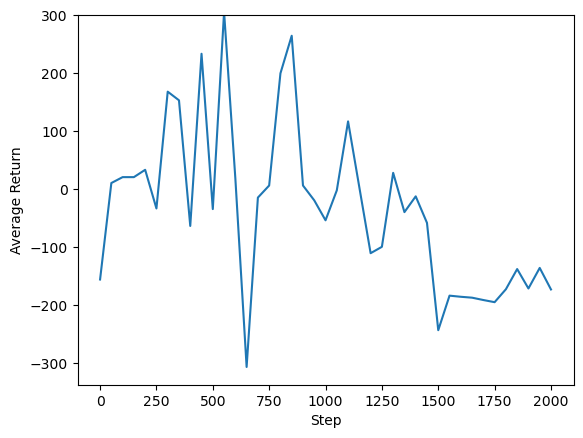

In [77]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=300)

### Videos

It is helpful to visualize the performance of an agent by rendering the environment at each step. Before we do that, let us first create a function to embed videos in this colab.

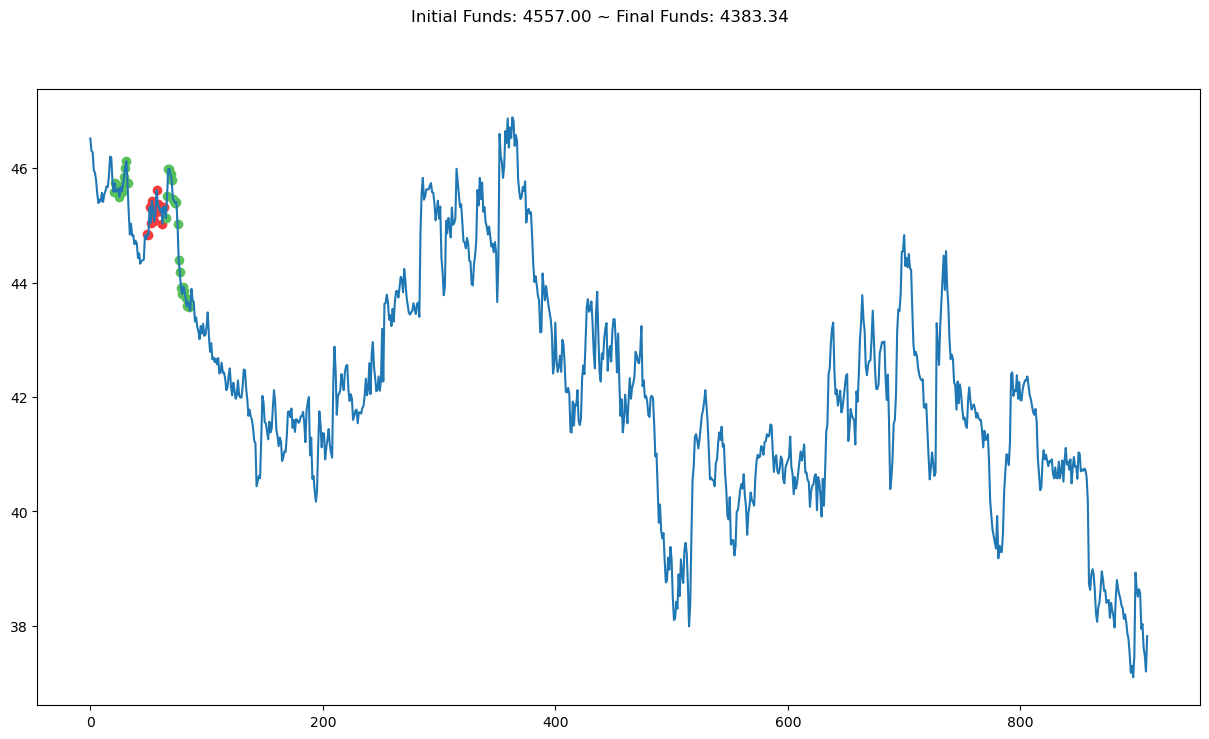

<Figure size 640x480 with 0 Axes>

In [73]:

def render_policy_eval(policy, filename):
    time_step = eval_env.reset()
    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
    eval_py_env.render('human')
    plt.savefig(filename)

render_policy_eval(tf_agent.policy, "trained-agent")

The following code visualizes the agent's policy for a few episodes:

In [74]:
#render_policy_eval(tf_agent.policy, "trained-agent")

In [75]:
random_policy = random_tf_policy.RandomTFPolicy(eval_env.time_step_spec(),
                                                eval_env.action_spec())

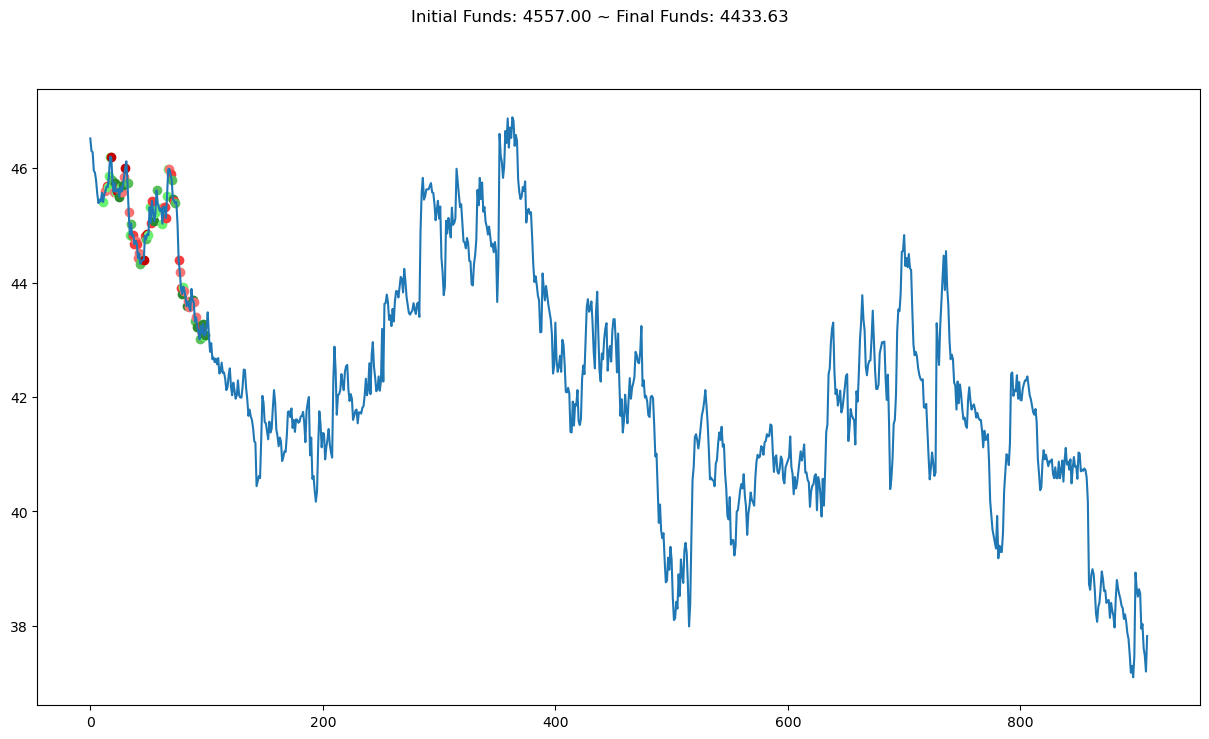

<Figure size 640x480 with 0 Axes>

In [76]:
render_policy_eval(random_policy, "random-agent")